# Setup

**This code was executed using an NVIDIA A100 GPU on Google Colab.**

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
from scipy.stats import gaussian_kde

from typing import Any, Dict, Tuple, List, Optional

import tensorflow as tf
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    explained_variance_score
)

import datetime

plt.rcParams.update({
    "xtick.top": False,
    "ytick.right": False,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid" : True,
    "grid.color": "gray",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "grid.alpha": 0.3,
})

In [2]:
# THIS CODE IS THE SAME AS THE ONE IN THE GEEXHP.MODELFUNCS.LOADINGDATA
# BUT IT IS HERE TO AVOID IMPORT IN THE COLAB NOTEBOOK
def parse_example(
    example_proto: tf.Tensor,
    input_stats: Dict[str, Tuple[float, float]],
    output_stats: Dict[str, Any]
) -> Tuple[Dict[str, tf.Tensor], Dict[str, List[tf.Tensor]]]:
    """
    Parse a single tf.train.Example proto using provided normalization statistics.

    Parameters
    ----------
    example_proto : tf.Tensor
        A serialized Example proto containing raw features.
    input_stats : dict
        Normalization statistics for input features. Keys are regions ('UV', 'Vis', 'NIR')
        with corresponding tuples (mean, std).
    output_stats : dict
        Normalization and transformation statistics for output features.

    Returns
    -------
    tuple
        A tuple (normalized_inputs, grouped_outputs) where:
          - normalized_inputs is a dict mapping feature names to normalized tf.Tensor inputs.
          - grouped_outputs is a dict with keys 'physical_output', 'main_chemical_output',
            and 'other_chemical_output', each containing a list of processed output tensors.
    """
    # 1) Define raw feature schemas.
    raw_input_features = {
        'NOISY_ALBEDO_SS-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_SS-UV':  tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_SS-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        # Planetary parameters.
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY":           tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE":   tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE":      tf.io.FixedLenFeature([], tf.float32),

        # Chemical abundances.
        'CH4':  tf.io.FixedLenFeature([], tf.float32),
        #'CO':   tf.io.FixedLenFeature([], tf.float32),
        'CO2':  tf.io.FixedLenFeature([], tf.float32),
        'H2O':  tf.io.FixedLenFeature([], tf.float32),
        'N2':   tf.io.FixedLenFeature([], tf.float32),
        #'N2O':  tf.io.FixedLenFeature([], tf.float32),
        'O2':   tf.io.FixedLenFeature([], tf.float32),
        'O3':   tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type': tf.io.FixedLenFeature([], tf.string)
    }

    # 2) Parse the example.
    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    # 3) Normalize input spectra.
    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_SS-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)

        mean = input_stats[region][0]
        std  = input_stats[region][1]
        normalized = (spectrum - mean) / std

        # Reshape for model (example shape)
        if region == 'UV':
            normalized = tf.reshape(normalized, [7, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [109, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [25, 1])

        normalized_inputs[f'NOISY_ALBEDO_SS-{region}'] = normalized

    # 4) Process outputs.
    physical_outputs = []
    main_chemical_outputs = []
    other_chemical_outputs = []

    # 4a) Process planetary parameters (physical outputs).
    for param in ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]:
        val = parsed[param]
        # To avoid a very ponctual error we found
        # the floating point precision error generates a single NaN value here :(
        if val == 273.15:
            val += 0.00002
        min_  = output_stats['physical_output_stats'][param][0]
        max_  = output_stats['physical_output_stats'][param][1]
        best_n  = output_stats['physical_output_stats'][param][2]
        processed = (val - min_) / (max_ - min_)
        processed = tf.math.pow(float(processed), float(1/best_n))
        physical_outputs.append(processed)

    # 4b) Process main chemical abundances.
    for chem in ['O2', 'O3']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1/best_n))
        main_chemical_outputs.append(processed)

    # 4c) Process other chemical abundances.
    for chem in ['CH4', 'CO2', 'H2O', 'N2']:
        val = parsed[chem]
        best_n = output_stats['chemical_output_stats'][chem]["best_n"]
        processed = tf.math.pow(float(val), float(1 / best_n))
        other_chemical_outputs.append(processed)

    grouped_outputs = {
        'physical_output': physical_outputs,              # shape (4,)
        'main_chemical_output': main_chemical_outputs,    # shape (2,)
        'other_chemical_output': other_chemical_outputs,  # shape (7,)
        #'earth_type': parsed['Earth_type']               # shape (1,)
    }

    return normalized_inputs, grouped_outputs


def read_tfrecord(
    file_path: str,
    batch_size: int = 1024,
    shuffle_buffer: Optional[int] = None,
    repeat: bool = False
) -> tf.data.Dataset:
    """
    Read a TFRecord file, parse its examples, and return a batched tf.data.Dataset.

    Parameters
    ----------
    file_path : str
        Path to the TFRecord file.
    batch_size : int, optional
        Number of samples per batch, by default 256.
    shuffle_buffer : int, optional
        Buffer size for shuffling. If None or <= 0, shuffling is not applied.
    repeat : bool, optional
        Whether to repeat the dataset indefinitely, by default False.

    Returns
    -------
    tf.data.Dataset
        A dataset of parsed examples, batched and prefetched.
    """
    with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
        stats = json.load(f)

    # Create lookup dictionaries for input normalization statistics.
    input_stats = {
        'UV': (stats['inputs']['SS-UV']['mean'], stats['inputs']['SS-UV']['std']),
        'Vis': (stats['inputs']['SS-Vis']['mean'], stats['inputs']['SS-Vis']['std']),
        'NIR': (stats['inputs']['SS-NIR']['mean'], stats['inputs']['SS-NIR']['std'])
    }

    physical_keys = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY",
                    "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
    physical_output_stats = {
        key: (stats['outputs'][key]['min'], stats['outputs'][key]['max'], stats['outputs'][key]['best_n'])
        for key in physical_keys
    }

    chemical_keys = ['CH4', 'CO2', 'H2O', 'N2', 'O2', 'O3']
    chemical_output_stats = {
        key: stats['outputs'][key] for key in chemical_keys
    }

    output_stats: Dict[str, Any] = {
        'physical_output_stats': physical_output_stats,
        'chemical_output_stats': chemical_output_stats
    }

    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset using the parse_example function.
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)

    return parsed_dataset

In [3]:
train_ds = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/train.tfrecord", shuffle_buffer=800000, repeat=True)
val_ds   = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/val.tfrecord", shuffle_buffer=80000, repeat=True)
test_ds  = read_tfrecord("/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/test.tfrecord")

In [4]:
TRAIN_SAMPLES = 892073
VAL_SAMPLES = 107422
BATCH_SIZE = 1024

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

# BAYESIAN TUNER

In [5]:
%%capture
!pip install keras-tuner
import kerastuner as kt

In [6]:
def residual_block_1D(x,
                      num_filters=32,
                      kernel_size=3,
                      activation='swish',
                      padding='same',
                      strides=1, dropout_rate=0.25):
    shortcut = x
    # First Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Activation(activation)(y)
    y = tf.keras.layers.SpatialDropout1D(rate=dropout_rate)(y, training=True)
    # Second Conv
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, activation=None)(y)
    y = tf.keras.layers.BatchNormalization()(y)
    # Skip connection
    y = tf.keras.layers.Add()([shortcut, y])
    y = tf.keras.layers.Activation(activation)(y)
    y = tf.keras.layers.MaxPooling1D(pool_size=1)(y)
    y = tf.keras.layers.SpatialDropout1D(rate=dropout_rate)(y, training=True)
    y = tf.keras.layers.Conv1D(num_filters, kernel_size, padding=padding, strides=strides, activation=None)(y)
    return y

def small_transformer_block(x,
                            num_heads=4,
                            key_dim=32):
    # Self-Attention
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = tf.keras.layers.Add()([x, attn_output])
    x = tf.keras.layers.LayerNormalization()(x)
    # Feed-forward
    ff = tf.keras.layers.Dense(64, activation='swish')(x)
    ff = tf.keras.layers.Dense(x.shape[-1])(ff)  # project back to input feature dim
    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization()(x)
    return x

def build_model(hp):
    """
    HyperModel for your CNN with Bayesian optimization. The model:
      - Takes three spectral inputs (UV, VIS, NIR)
      - Merges them and applies two residual blocks with large kernel sizes for near-global coverage
      - Applies a small transformer block
      - Uses dense layers with dropout, and two sub-heads for physical and chemical outputs.
    """
    # ----------------------
    #  Target Definitions
    # ----------------------
    physical_targets = [
        "OBJECT-RADIUS-REL-EARTH",
        "OBJECT-GRAVITY",
        "ATMOSPHERE-TEMPERATURE",
        "ATMOSPHERE-PRESSURE"
    ]
    main_chemical_targets = ['O2', 'O3']
    other_chemical_targets = ['CH4', 'CO2', 'H2O', 'N2']

    # ----------------------
    #   Input Layers
    # ----------------------
    input_uv  = tf.keras.layers.Input(shape=(7, 1),  name='NOISY_ALBEDO_SS-UV')
    input_vis = tf.keras.layers.Input(shape=(109, 1), name='NOISY_ALBEDO_SS-Vis')
    input_nir = tf.keras.layers.Input(shape=(25, 1), name='NOISY_ALBEDO_SS-NIR')
    # Concatenate along the spectral dimension.
    spectrum = tf.keras.layers.Concatenate(axis=1)([input_uv, input_vis, input_nir])
    spectrum_length = 141  # Total length

    # ----------------------
    #   Hyperparameters
    # ----------------------
    # Convolutional block hyperparameters
    num_filters = hp.Int('num_filters', min_value=16, max_value=64, step=8, default=20)
    kernel_size_1 = hp.Choice('kernel_size_1',
                              values=[max(3, int(spectrum_length/4)), int(spectrum_length/3), int(spectrum_length/2)],
                              default=int(spectrum_length/4))
    kernel_size_2 = hp.Choice('kernel_size_2',
                              values=[int(spectrum_length/2), int(spectrum_length*0.75), spectrum_length],
                              default=int(spectrum_length/2))
    # Transformer block hyperparameters
    num_heads = hp.Int('num_heads', min_value=2, max_value=4, step=1, default=2)
    key_dim = hp.Int('key_dim', min_value=8, max_value=16, step=4, default=8)
    # Dense block and dropout hyperparameters
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16, default=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.25, max_value=0.5, step=0.05, default=0.25)
    # Optimizer learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG', default=1e-4)

    # ----------------------
    #   Model Architecture
    # ----------------------
    # Residual blocks with large kernels for near-global coverage.
    spectrum = residual_block_1D(spectrum,
                                 num_filters=num_filters,
                                 kernel_size=kernel_size_1,
                                 strides=2, dropout_rate=dropout_rate)
    spectrum = residual_block_1D(spectrum,
                                 num_filters=num_filters,
                                 kernel_size=kernel_size_2,
                                 strides=2, dropout_rate=dropout_rate)
    # Transformer block
    spectrum = small_transformer_block(spectrum, num_heads=num_heads, key_dim=key_dim)
    # Global pooling to reduce dimensionality.
    spectrum = tf.keras.layers.GlobalAveragePooling1D()(spectrum)

    # Dense layers with skip connection.
    shortcut = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(spectrum)
    x = tf.keras.layers.Dropout(dropout_rate)(shortcut, training=True)
    x = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x, training=True)
    x = tf.keras.layers.Dense(dense_units, kernel_initializer="he_normal")(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x, training=True)
    x = tf.keras.layers.Add()([shortcut, x])

    # ----------------------
    #   Sub-heads for Outputs
    # ----------------------
    # Physical parameters head (4 outputs)
    phys = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="glorot_uniform")(x)
    phys_out = tf.keras.layers.Dense(
        len(physical_targets),
        activation='sigmoid',
        name='physical_output'
    )(phys)

    # Main chemical abundances head (2 outputs)
    main_chem = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="he_normal")(x)
    main_chem_out_dense = tf.keras.layers.Dense(
        len(main_chemical_targets),
        activation=None,
        name='main_chem_dense'
    )(main_chem)
    main_chem_out = tf.keras.layers.ReLU(max_value=1.0, name='main_chemical_output')(main_chem_out_dense)

    # Other chemical abundances head (4 outputs)
    other_chem = tf.keras.layers.Dense(dense_units // 2, kernel_initializer="he_normal")(x)
    other_chem_out_dense = tf.keras.layers.Dense(
        len(other_chemical_targets),
        activation=None,
        name='other_chem_dense'
    )(other_chem)
    other_chem_out = tf.keras.layers.ReLU(max_value=1.0, name='other_chemical_output')(other_chem_out_dense)

    outputs = {
        'physical_output': phys_out,
        'main_chemical_output': main_chem_out,
        'other_chemical_output': other_chem_out
    }

    model = tf.keras.Model(
        inputs=[input_uv, input_vis, input_nir],
        outputs=outputs,
        name="Net22_hyper"
    )

    # ----------------------
    #   Compilation
    # ----------------------
    losses = {
        'physical_output': 'mae',
        'main_chemical_output': 'mae',
        'other_chemical_output': 'mae'
    }
    loss_weights = {
        'physical_output': 1.0,
        'main_chemical_output': 2.0,
        'other_chemical_output': 1.5
    }
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(
        optimizer=opt,
        loss=losses,
        loss_weights=loss_weights
    )

    return model

In [7]:
tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=30,
    directory="/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/hypertuning_HABEX-NEW",
    project_name="net22_bayesian"
)

In [8]:
# Total elapsed time: 01h 43m 19s
tuner.search(train_ds, epochs=3, validation_data=val_ds,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps)

Trial 30 Complete [00h 03m 29s]
val_loss: 0.29497793316841125

Best val_loss So Far: 0.2874119281768799
Total elapsed time: 01h 43m 19s


In [9]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
display("Best hyperparameters:", best_hp.values)

'Best hyperparameters:'

{'num_filters': 56,
 'kernel_size_1': 35,
 'kernel_size_2': 141,
 'num_heads': 4,
 'key_dim': 16,
 'dense_units': 16,
 'dropout_rate': 0.35,
 'learning_rate': 0.001}

In [10]:
best_model = tuner.hypermodel.build(best_hp)

In [11]:
EPOCHS = 50

log_dir = "/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/logsHABEX-NEW/fit22/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.6,       # How much to reduce LR by
    patience=5,       # Wait 3 epochs with no improvement before reducing LR
    min_lr=1e-7,      # Lower bound on LR
    cooldown=0,
    verbose=1
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,       # Number of epochs with no improvement after which training stops
    restore_best_weights=True,  # Revert to the best weights found during training
    verbose=1
)

history = best_model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[
        tensorboard_callback,
        reduce_lr_callback,
        early_stop_callback
    ]
)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 79s 53ms/step - loss: 0.9849 - main_chemical_output_loss: 0.1862 - other_chemical_output_loss: 0.2284 - physical_output_loss: 0.2700 - val_loss: 0.3653 - val_main_chemical_output_loss: 0.0459 - val_other_chemical_output_loss: 0.0870 - val_physical_output_loss: 0.1429 - learning_rate: 0.0010
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 80s 92ms/step - loss: 0.3770 - main_chemical_output_loss: 0.0496 - other_chemical_output_loss: 0.0881 - physical_output_loss: 0.1456 - val_loss: 0.3022 - val_main_chemical_output_loss: 0.0390 - val_other_chemical_output_loss: 0.0702 - val_physical_output_loss: 0.1190 - learning_rate: 0.0010
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - loss: 0.3164 - main_chemical_output_loss: 0.0413 - other_chemical_output_loss: 0.0729 - physical_output_loss: 0.1244 - val_loss: 0.2884 - val_main_chemical_output_loss: 0.0371 - val_other_chemical_output_loss: 0.0666 - val_physical_output_loss: 0.1144 - learning_rate: 0.0010
Epoc

41 min, 50/50 epochs

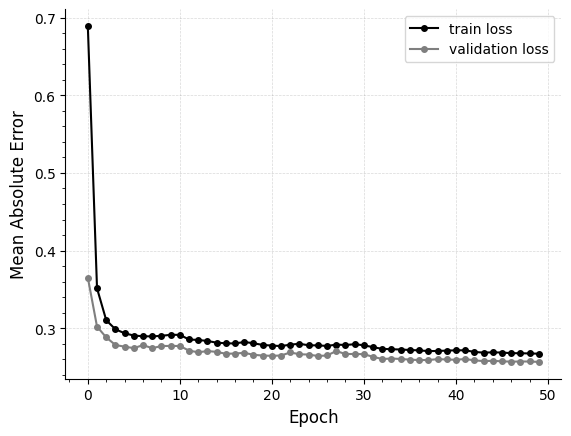

In [12]:
plt.plot(range(EPOCHS), history.history["loss"], marker="o", label="train loss", color="k", markersize=4)
plt.plot(range(EPOCHS), history.history["val_loss"], marker="o", label="validation loss", color="tab:gray", markersize=4)
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend();

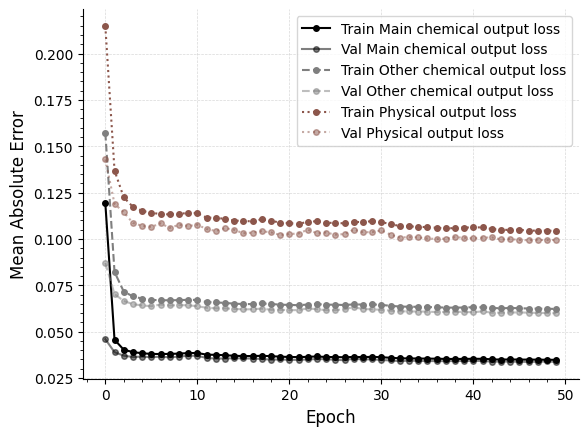

In [13]:
plt.plot(range(EPOCHS), history.history["main_chemical_output_loss"], marker="o", label="Train Main chemical output loss", color="k", markersize=4)
plt.plot(range(EPOCHS), history.history["val_main_chemical_output_loss"], marker="o", label="Val Main chemical output loss", color="k", alpha=0.5, markersize=4)

plt.plot(range(EPOCHS), history.history["other_chemical_output_loss"], marker="o", ls="dashed", label="Train Other chemical output loss", color="tab:gray", markersize=4)
plt.plot(range(EPOCHS), history.history["val_other_chemical_output_loss"], marker="o", ls="dashed", label="Val Other chemical output loss", color="tab:gray", alpha=0.5, markersize=4)

plt.plot(range(EPOCHS), history.history["physical_output_loss"], marker="o", ls="dotted", label="Train Physical output loss", color="tab:brown", markersize=4)
plt.plot(range(EPOCHS), history.history["val_physical_output_loss"], marker="o", ls="dotted", label="Val Physical output loss", color="tab:brown", alpha=0.5, markersize=4)

plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend();

In [14]:
best_model.save('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/HABEX_NEW.keras')

In [15]:
y_true_phys_all = []
y_true_main_chem_all = []
y_true_other_chem_all = []

y_pred_phys_all = []
y_pred_main_chem_all = []
y_pred_other_chem_all = []

for x_batch, y_batch in test_ds:
    # 1) Get model predictions for this batch
    predictions = best_model(x_batch, training=False)
    pred_phys_batch = predictions['physical_output']
    pred_main_chem_batch = predictions['main_chemical_output']
    pred_other_chem_batch = predictions['other_chemical_output']

    # 2) Collect ground-truth values
    true_phys_batch = y_batch['physical_output']
    true_main_chem_batch = y_batch['main_chemical_output']
    true_other_chem_batch = y_batch['other_chemical_output']

    # 3) Append to our running lists
    y_true_phys_all.append(true_phys_batch.numpy())
    y_true_main_chem_all.append(true_main_chem_batch.numpy())
    y_true_other_chem_all.append(true_other_chem_batch.numpy())

    y_pred_phys_all.append(pred_phys_batch.numpy())
    y_pred_main_chem_all.append(pred_main_chem_batch.numpy())
    y_pred_other_chem_all.append(pred_other_chem_batch.numpy())

# 4) Concatenate the list of batches into a single array for each head
y_true_phys_all = np.concatenate(y_true_phys_all, axis=0)
y_true_main_chem_all = np.concatenate(y_true_main_chem_all, axis=0)
y_true_other_chem_all = np.concatenate(y_true_other_chem_all, axis=0)

y_pred_phys_all = np.concatenate(y_pred_phys_all, axis=0)
y_pred_main_chem_all = np.concatenate(y_pred_main_chem_all, axis=0)
y_pred_other_chem_all = np.concatenate(y_pred_other_chem_all, axis=0)

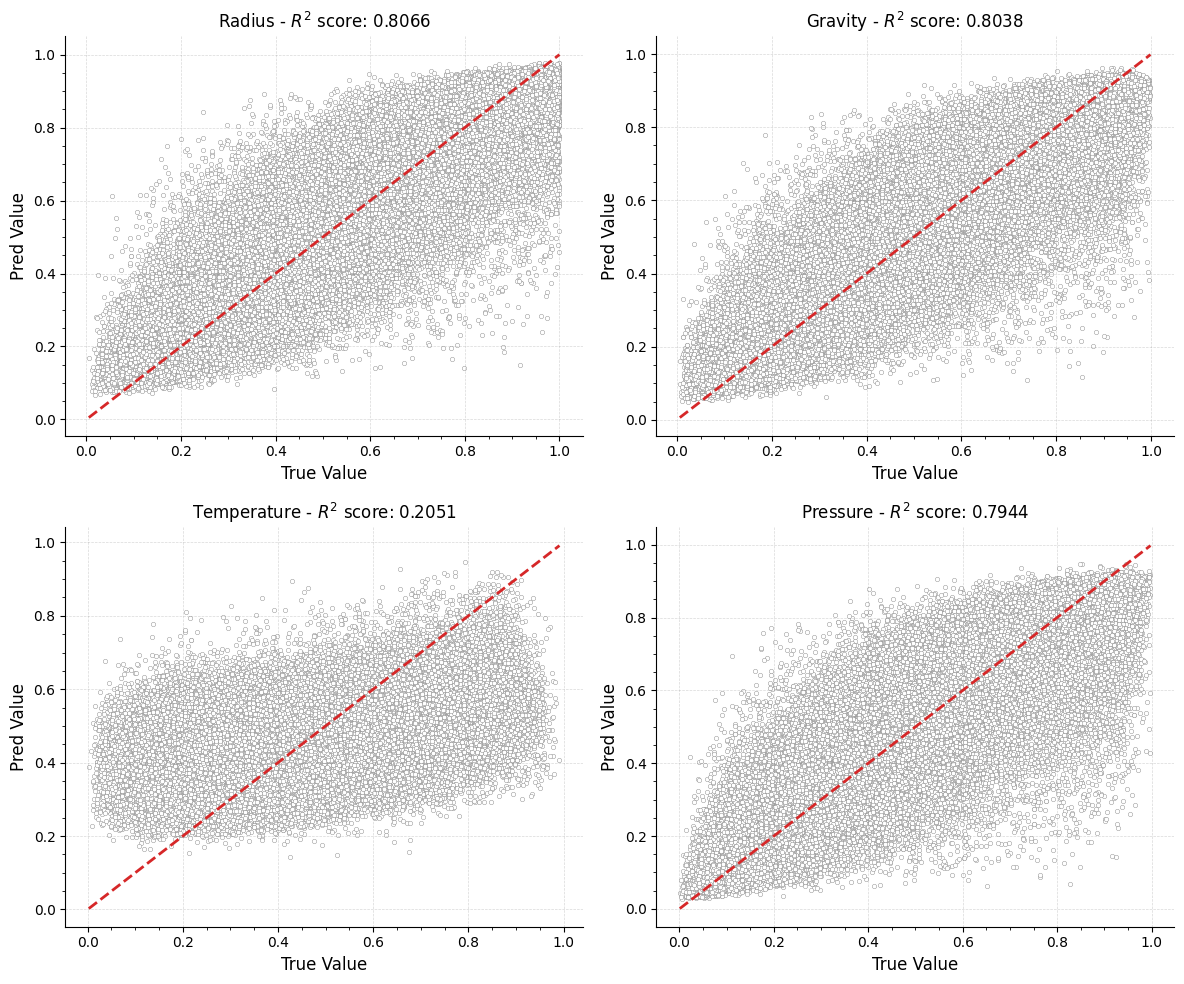

In [16]:
physical_parameters = ['Radius', 'Gravity', 'Temperature', 'Pressure']
n_keys = len(physical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 10))

metrics_list = []

for i, phys_param in enumerate(physical_parameters):
    phys_true = np.array([y_true_phys_all[row][i] for row in range(len(y_true_phys_all))])
    phys_pred = np.array([y_pred_phys_all[row][i] for row in range(len(y_pred_phys_all))])

    min_val = min(phys_true.min(), phys_pred.min())
    max_val = max(phys_true.max(), phys_pred.max())

    r2 = r2_score(phys_true, phys_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    ax.scatter(phys_true, phys_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    ax.set_title(fr'{physical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(phys_true, phys_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(phys_true, phys_pred)
    med_ae = median_absolute_error(phys_true, phys_pred)
    exp_var = explained_variance_score(phys_true, phys_pred)

    metrics_list.append({
        "Output": phys_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
plt.tight_layout();

In [17]:
df_metrics

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,Radius,0.806621,0.807028,0.012506,0.111832,0.082746,0.061774
1,Gravity,0.803833,0.804129,0.012716,0.112763,0.083341,0.062295
2,Temperature,0.205123,0.205604,0.033694,0.183559,0.149544,0.131163
3,Pressure,0.794356,0.794361,0.013844,0.117659,0.084471,0.059536


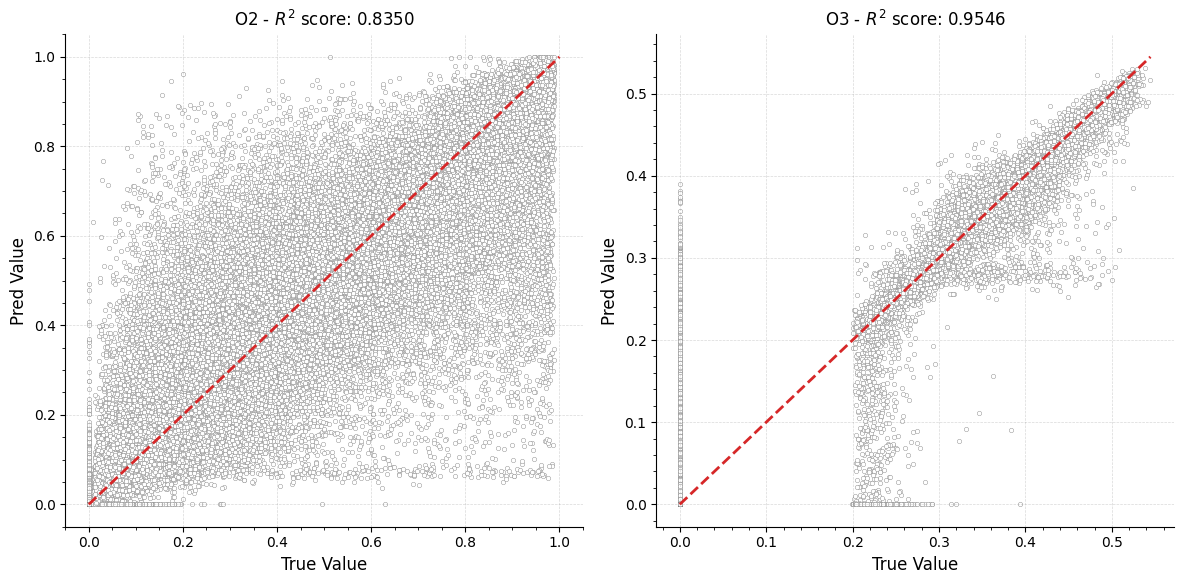

In [18]:
main_chemical_parameters = ['O2', 'O3']

n_keys = len(main_chemical_parameters)
n_cols = 2
n_rows = int(np.ceil(n_keys / n_cols))

plt.figure(figsize=(12, 6))

metrics_list = []

for i, chem_param in enumerate(main_chemical_parameters):
    chem_true = np.array([y_true_main_chem_all[row][i] for row in range(len(y_true_main_chem_all))])
    chem_pred = np.array([y_pred_main_chem_all[row][i] for row in range(len(y_pred_main_chem_all))])

    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    ax.set_title(fr'{main_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics_chem = pd.DataFrame(metrics_list)
plt.tight_layout()
plt.show()

In [19]:
df_metrics_chem

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,O2,0.834953,0.835151,0.014609,0.120868,0.062826,0.02080
1,O3,0.954611,0.954696,0.001281,0.035786,0.011000,0.00281


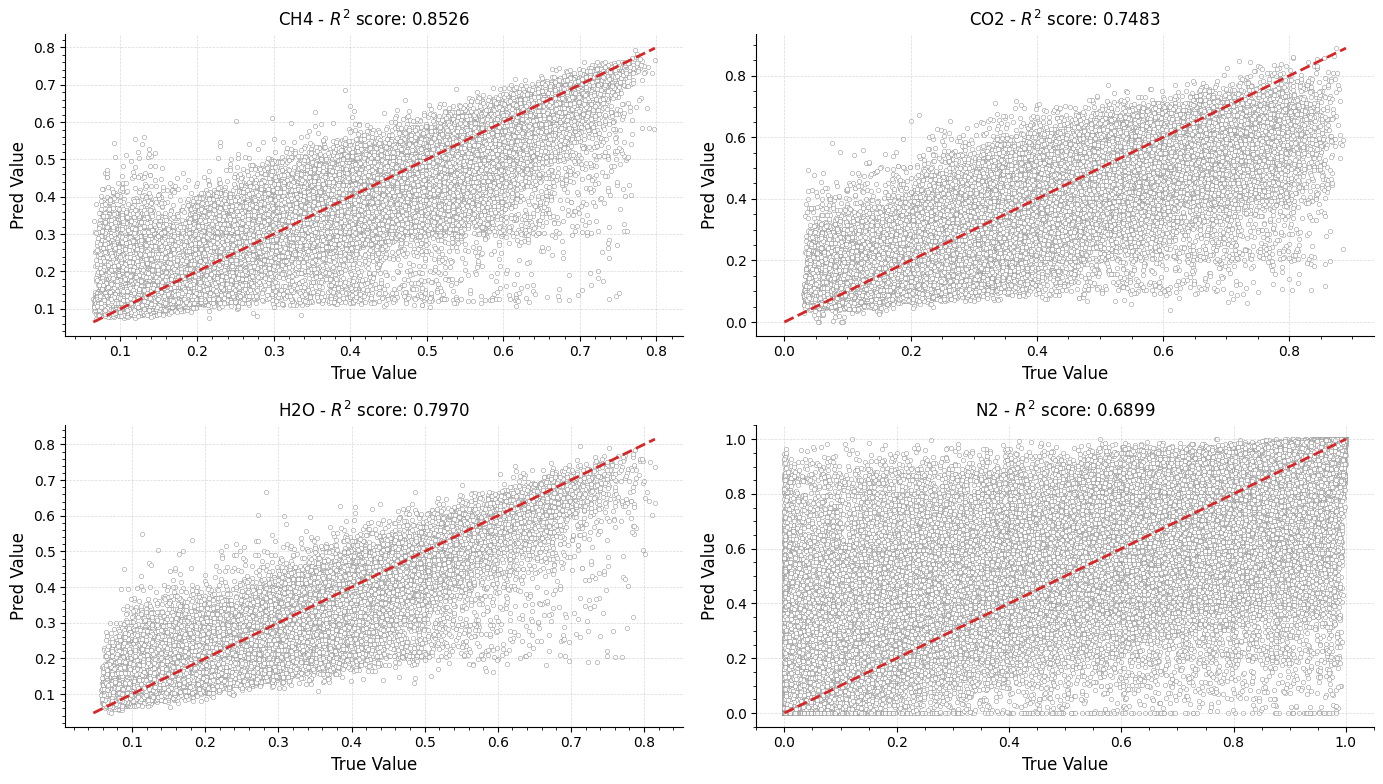

In [20]:
other_chemical_parameters = ['CH4', 'CO2', 'H2O', 'N2']

n_keys = len(other_chemical_parameters)
n_cols = 2
n_rows = 2
plt.figure(figsize=(14, 8))

metrics_list = []

for i, chem_param in enumerate(other_chemical_parameters):
    chem_true = np.array([y_true_other_chem_all[row][i] for row in range(len(y_true_other_chem_all))])
    chem_pred = np.array([y_pred_other_chem_all[row][i] for row in range(len(y_pred_other_chem_all))])

    # Correct min and max values using both true and pred arrays
    min_val = min(chem_true.min(), chem_pred.min())
    max_val = max(chem_true.max(), chem_pred.max())

    r2 = r2_score(chem_true, chem_pred)

    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)

    ax.scatter(chem_true, chem_pred, s=10, edgecolor="tab:gray", linewidth=0.3, color="w")

    ax.set_title(fr'{other_chemical_parameters[i]} - $R^2$ score: {r2:.4f}')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Pred Value")

    mse = mean_squared_error(chem_true, chem_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(chem_true, chem_pred)
    med_ae = median_absolute_error(chem_true, chem_pred)
    exp_var = explained_variance_score(chem_true, chem_pred)

    metrics_list.append({
        "Output": chem_param,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

plt.tight_layout()

df_metrics_chem = pd.DataFrame(metrics_list)
plt.show()

In [21]:
df_metrics_chem

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,CH4,0.852638,0.853347,0.003960,0.062925,0.040964,0.027181
1,CO2,0.748321,0.752384,0.007827,0.088470,0.057252,0.036063
2,H2O,0.796984,0.797442,0.002971,0.054510,0.036348,0.023734
3,N2,0.689875,0.691330,0.033060,0.181825,0.108014,0.045218


# CORNERPLOT

In [22]:
%%capture
!pip install corner

In [23]:
import corner

In [24]:
with open('/content/drive/MyDrive/CNN-MODELS-JUN-VERSION/DATA/normalization_stats.json') as f:
    stats = json.load(f)

phys_names = ["OBJECT-RADIUS-REL-EARTH", "OBJECT-GRAVITY", "ATMOSPHERE-TEMPERATURE", "ATMOSPHERE-PRESSURE"]
main_names = ["O2", "O3"]
other_names = ["CH4","CO2","H2O","N2"]
all_names = phys_names + main_names + other_names

def denorm_physical(processed, name):
    pmin, pmax, n = (stats['outputs'][name][k]
                     for k in ('min', 'max', 'best_n'))
    return (processed ** n) * (pmax - pmin) + pmin

def denorm_chem(processed, name):
    n = stats['outputs'][name]['best_n']
    return processed ** n

In [25]:
def sample_one(ds, skip=1):
    (x_batch, y_batch), = ds.skip(skip).take(1)
    x = {k: v[0:1] for k, v in x_batch.items()}
    y = {k: v[0:1] for k, v in y_batch.items()}
    return x, y


def mc_draws(mc_model, x, T=300):
    # Tile every feature tensor T times along the batch axis (axis=0)
    tiled_x = {k: tf.repeat(v, repeats=T, axis=0) for k, v in x.items()}

    # One stochastic forward pass with dropout active
    out = mc_model(tiled_x, training=True)

    # Reshape outputs individualmente
    physical_draws = tf.reshape(out['physical_output'], (T, -1)).numpy()
    main_chemical_draws = tf.reshape(out['main_chemical_output'], (T, -1)).numpy()
    other_chemical_draws = tf.reshape(out['other_chemical_output'], (T, -1)).numpy()

    return physical_draws, main_chemical_draws, other_chemical_draws

In [83]:
x, y = sample_one(test_ds, skip=53)

phys_draws, main_chem_draws, other_chem_draws = mc_draws(best_model, x, T=8000)

all_draws = np.concatenate([phys_draws, main_chem_draws, other_chem_draws], axis=1)

denorm_draws = []

for i, name in enumerate(phys_names):
    denorm_draws.append(denorm_physical(all_draws[:, i], name))

for i, name in enumerate(main_names):
    val = denorm_chem(all_draws[:, len(phys_names) + i], name)
    denorm_draws.append(np.log10(val))

offset = len(phys_names) + len(main_names)
for i, name in enumerate(other_names):
    val = denorm_chem(all_draws[:, offset + i], name)
    # botei esse 1e-15 só para evitar os casso que o modelo adivinha exatamente 0
    denorm_draws.append(np.log10(val + 1e-20))

denorm_draws = np.stack(denorm_draws, axis=1)

In [84]:
truth_values = []

true_phys = y['physical_output'].numpy()[0]
true_main = y['main_chemical_output'].numpy()[0]
true_other = y['other_chemical_output'].numpy()[0]

for i, name in enumerate(phys_names):
    truth_values.append(denorm_physical(true_phys[i], name))

for name in main_names:
    val = denorm_chem(y['main_chemical_output'][0].numpy()[main_names.index(name)], name)
    truth_values.append(np.log10(val))

for name in other_names:
    val = denorm_chem(y['other_chemical_output'][0].numpy()[other_names.index(name)], name)
    truth_values.append(np.log10(val))

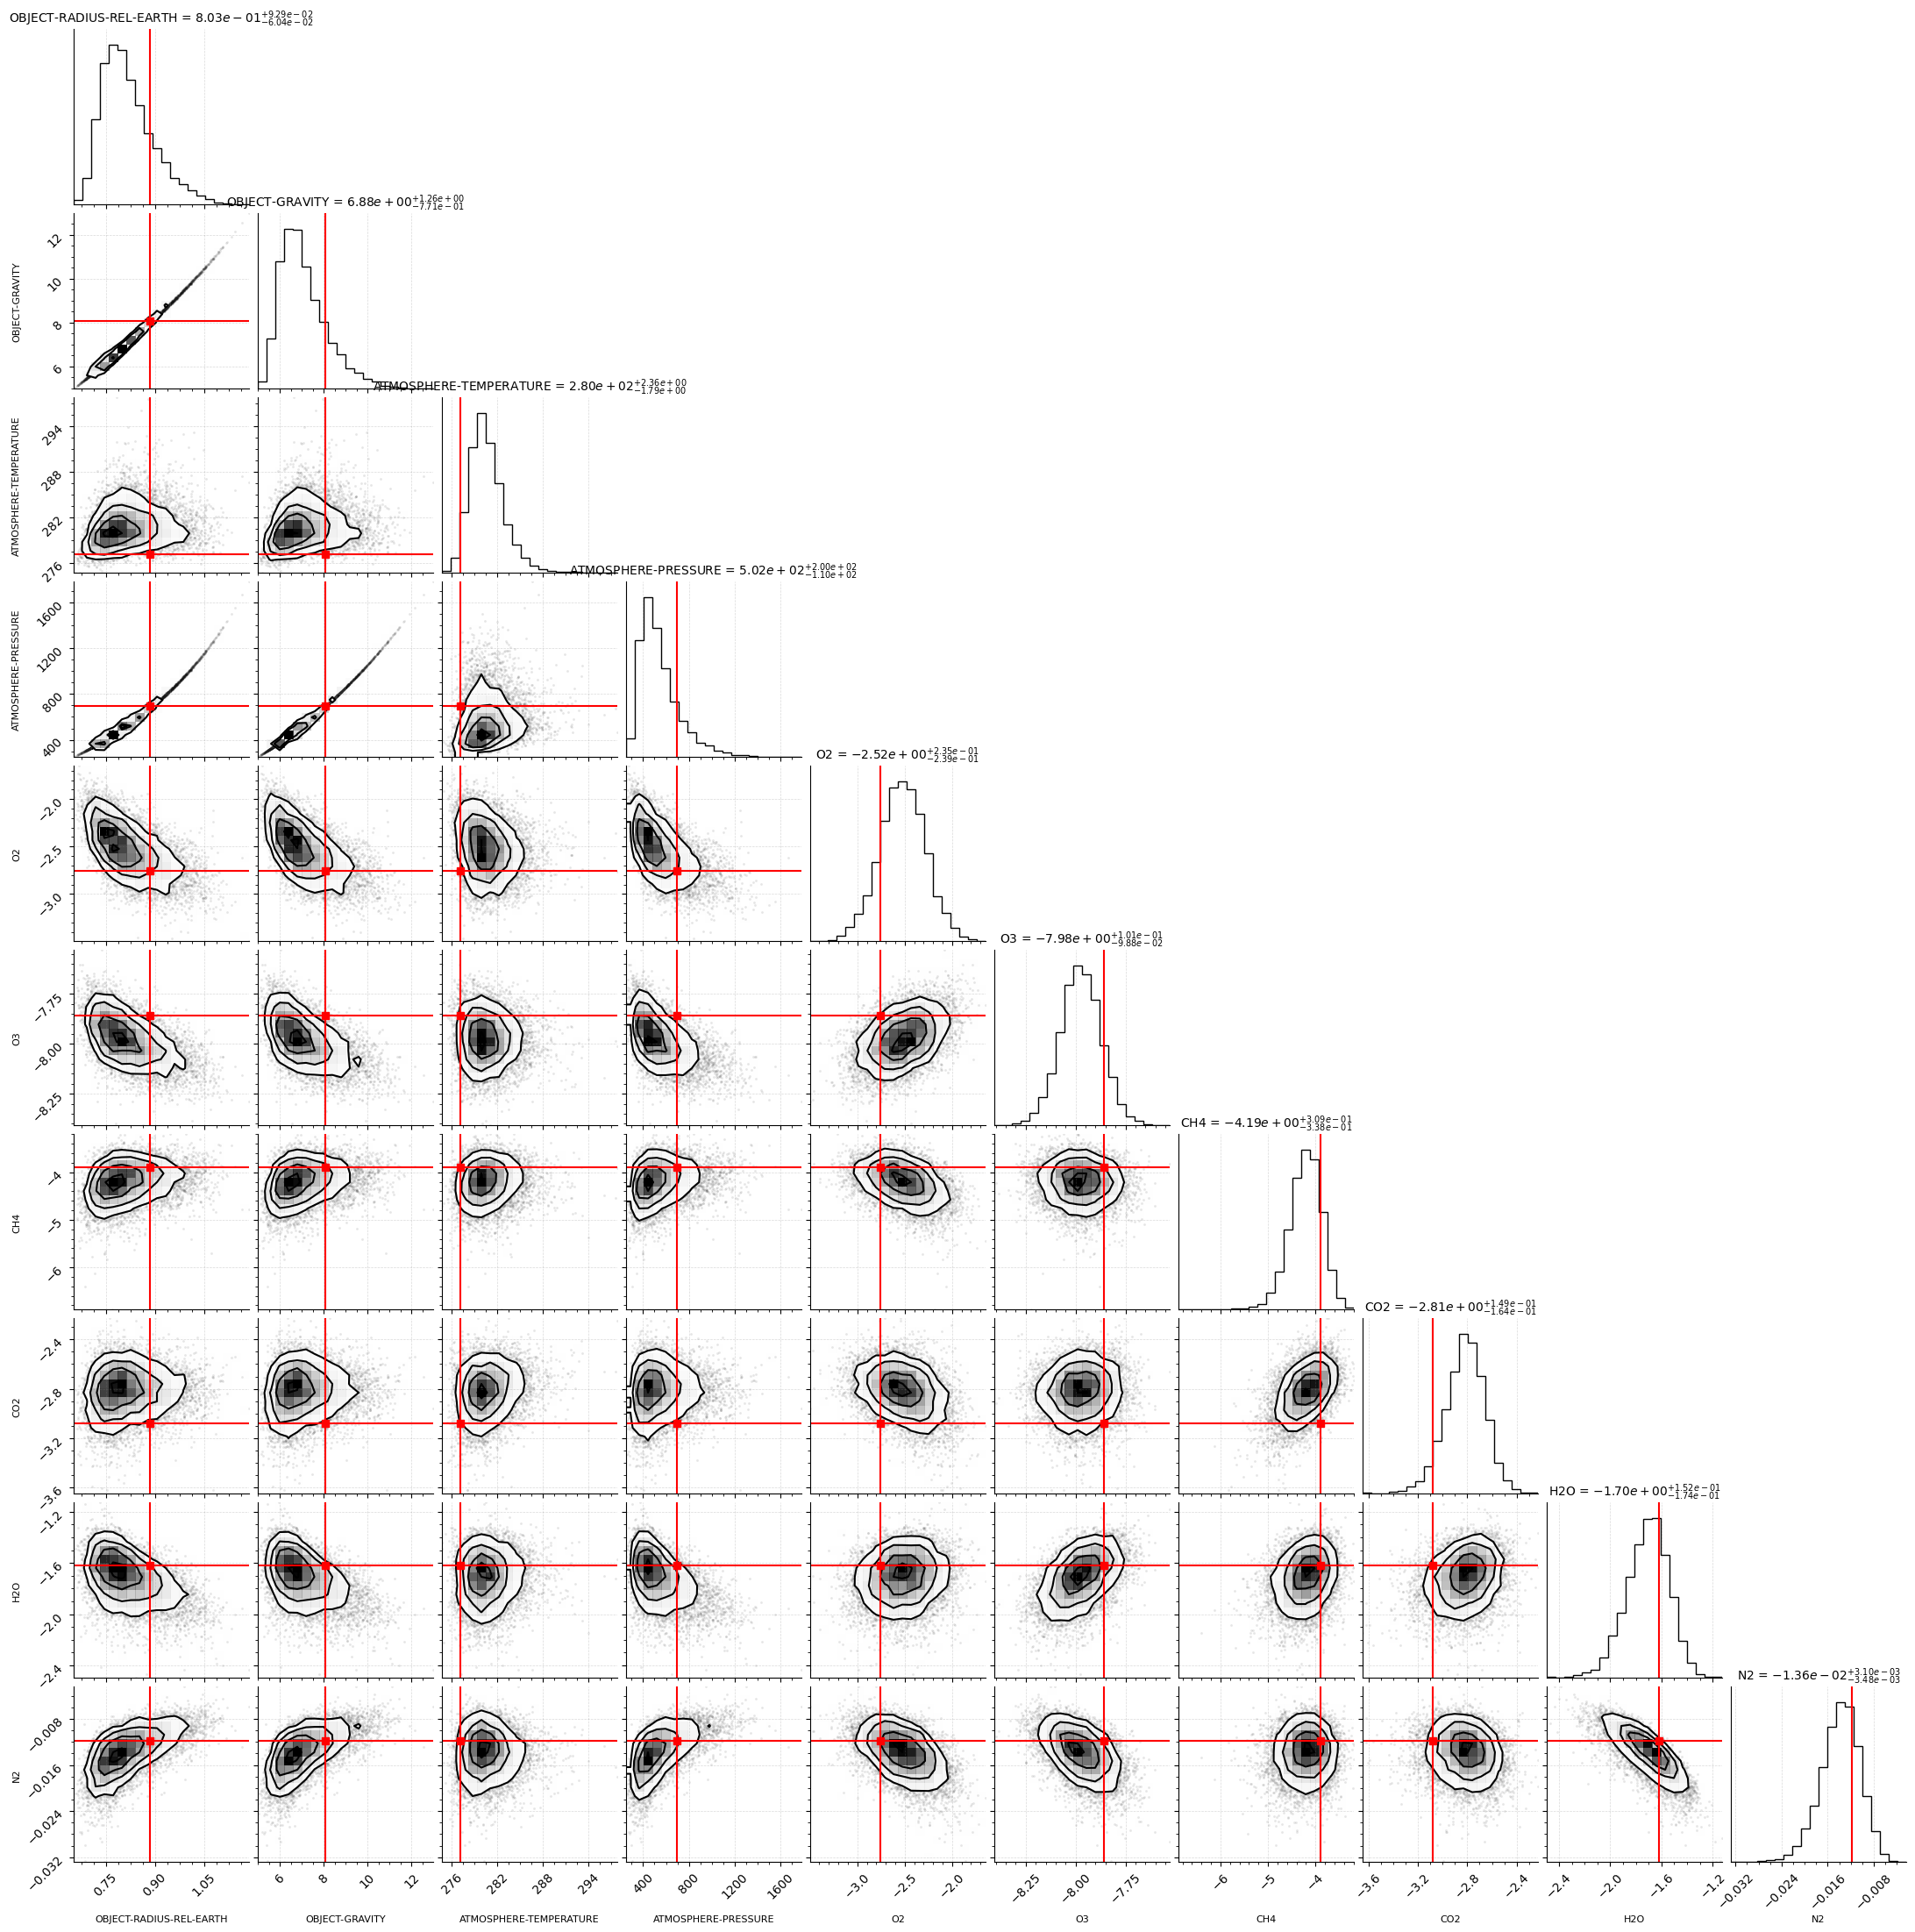

In [85]:
labels = phys_names + main_names + other_names

fig = corner.corner(
    denorm_draws,
    labels=labels,
    truths=truth_values,
    truth_color='red',
    show_titles=True,
    title_fmt=".2e",
    title_kwargs={"fontsize": 10},
    label_kwargs={"fontsize": 8},
    max_n_ticks=4
)
plt.show()